In [55]:
!pip install -U seaborn

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [1]:
import pandas as pd
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56,2017-10-02 11:07,2017-10-04 19:55,2017-10-10 21:25,2017-10-18 0:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41,2018-07-26 3:24,2018-07-26 14:31,2018-08-07 15:27,2018-08-13 0:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 8:38,2018-08-08 8:55,2018-08-08 13:50,2018-08-17 18:06,2018-09-04 0:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28,2017-11-18 19:45,2017-11-22 13:39,2017-12-02 0:28,2017-12-15 0:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18,2018-02-13 22:20,2018-02-14 19:46,2018-02-16 18:17,2018-02-26 0:00


In [6]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 9:45,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57,199.90,18.14


In [7]:
other_state_geolocation = geolocation.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)

In [8]:
geolocation_silver = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')

In [9]:
customers_silver = customers.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

In [10]:
geolocation_silver

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,1001,sao paulo,SP,-23.550498,-46.634027
1,1001,são paulo,SP,-23.549951,-46.634027
2,1002,sao paulo,SP,-23.548551,-46.635072
3,1002,são paulo,SP,-23.544641,-46.633180
4,1003,sao paulo,SP,-23.548976,-46.635318
...,...,...,...,...,...
27896,99965,agua santa,RS,-28.179542,-52.035551
27897,99970,ciriaco,RS,-28.343273,-51.873734
27898,99970,ciríaco,RS,-28.342325,-51.876023
27899,99980,david canabarro,RS,-28.388092,-51.846880


In [11]:
customers_silver

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409,franca,SP,-20.502070,-47.396822
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,14409,franca,SP,-20.502070,-47.396822
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,franca,SP,14409,franca,SP,-20.502070,-47.396822
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,franca,SP,14409,franca,SP,-20.502070,-47.396822
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,franca,SP,14409,franca,SP,-20.502070,-47.396822
...,...,...,...,...,...,...,...,...,...,...
148538,ff6b440b2465bfaef05c675efb48cd15,e38a27b979a552e019e297ecc22dc67b,98860,eugenio de castro,RS,98860,eugenio de castro,RS,-28.526971,-54.145383
148539,3f7029d9b98a47370cd5f3a97adcbccd,5894d202cc869b4ec460fce3c6ed8cb5,5538,sao paulo,SP,5538,sao paulo,SP,-23.588504,-46.737870
148540,d9110683c7a282144e9fc97660026a28,5cbfdb85ec130898108b32c50d619c39,74980,aparecida de goiania,GO,74980,aparecida de goiania,GO,-16.822945,-49.244615
148541,d9110683c7a282144e9fc97660026a28,5cbfdb85ec130898108b32c50d619c39,74980,aparecida de goiania,GO,74980,aparecida de goiânia,GO,-16.823261,-49.247368


In [12]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()

In [13]:
order_items_silver

,order_id,price,freight_value,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,2017-09-19 9:45
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,2017-05-03 11:05
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,2018-01-18 14:48
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,2018-08-15 10:10
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,2017-02-13 13:57
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,2018-05-02 4:11
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,2018-07-20 4:31
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,2017-10-30 17:14
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,2017-08-21 0:04


In [30]:
rfm_data

,customer_id,recency,frequency,monetary,R,F,M,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,1,Potential Loyslist
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,Potential Loyslist
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1,Hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,About to Sleep
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,2,Potential Loyslist
...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,1,1,4,At Risk
95416,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,3,1,1,Potential Loyslist
95417,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1,1,Hibernating
95418,ffff5962728ec6157033ef9805bacc48,124,1,115.00,4,1,1,Potential Loyslist


In [14]:
orders_silver = orders.merge(order_items_silver,on='order_id',how='inner')

In [15]:
orders_customers = customers.merge(orders_silver, on='customer_id', how='inner')

In [16]:
orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers['order_purchase_timestamp'])

In [17]:
max_date = max(orders_customers['order_purchase_timestamp']) + dt.timedelta(days=1)

In [18]:
rfm_data = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

In [32]:
orders_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'price', 'freight_value',
       'shipping_limit_date'],
      dtype='object')

In [31]:
rfm_data.columns

Index(['customer_id', 'recency', 'frequency', 'monetary', 'R', 'F', 'M',
       'segment'],
      dtype='object')

In [40]:
merged_rfm_data = pd.merge(orders_customers, rfm_data, how='left', on='customer_id')

In [41]:
merged_rfm_data.groupby('frequency')['customer_city'].count()

Series([], Name: customer_city, dtype: int64)

In [20]:
print(rfm_data[rfm_data['frequency']>1].shape[0] / rfm_data.shape[0])
print(rfm_data['frequency'].describe())

0.030528191154894153
count    95420.000000
mean         1.034018
std          0.211234
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64


In [21]:
print(rfm_data['monetary'].describe())

count    95420.000000
mean       142.440198
std        217.656355
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64


Customer Score:

The customer score ranges from 1 to 5, where the higher this number, the better. This score is assigned for each acronym independently:

The more recent the customer's purchase the higher the Recency (R) score.
The more purchases the customer makes, the higher the Frequency score (F)
The more the customer spends on purchases, the higher the score the customer will have Monetarity(M)

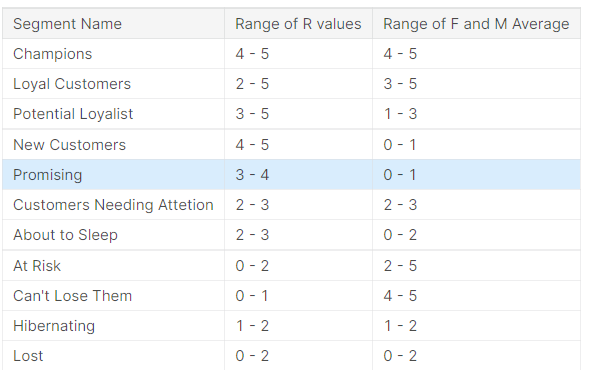

In [22]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

In [23]:
r_labels = k_means_group(rfm_data[['recency']],5,1,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],5,1)
m_labels = k_means_group(rfm_data[['monetary']],5,1)

rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels) 

In [24]:
rfm_data.groupby('R')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
1,12385.0,514.573759,50.444994,447.0,474.0,507.0,546.0,729.0
2,15934.0,379.632672,35.570759,321.0,349.0,379.0,410.0,446.0
3,22608.0,262.680688,30.690411,210.0,234.0,267.0,284.0,320.0
4,24554.0,156.245133,30.540803,105.0,129.0,156.0,183.0,209.0
5,19939.0,52.518080,27.072252,1.0,29.0,48.0,76.0,104.0


In [25]:
rfm_data.groupby('F')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,92507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2673.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,221.0,3.131222,0.338409,3.0,3.0,3.0,3.0,4.0
4,18.0,5.833333,1.098127,5.0,5.0,5.5,6.0,9.0
5,1.0,16.000000,NaN,16.0,16.0,16.0,16.0,16.0


In [26]:
rfm_data.groupby('M')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
1,73191.0,72.885003,40.914811,0.85,39.000,65.90,102.9,162.23
2,18029.0,251.560525,75.739841,162.38,189.900,229.00,299.7,467.00
3,3396.0,682.373448,166.715107,467.40,549.000,635.95,798.0,1117.80
4,731.0,1554.758906,347.611631,1119.90,1273.945,1440.00,1797.0,2589.00
5,73.0,3669.366438,1611.392852,2649.00,2849.900,3089.00,3980.0,13440.00


In [27]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Champions'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyal Customers'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Potential Loyslist'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'New Customers'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promising'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Customer Needing Attention'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'About to Sleep'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'At Risk'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Can't Lose Then"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Hibernating'
    return 'Lost'

In [28]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

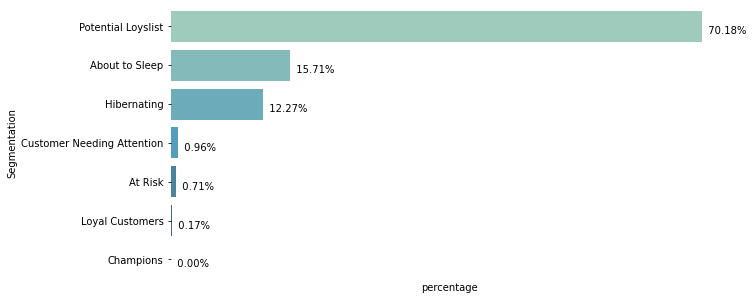

In [29]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

In [ ]:
Potential Loyslist -> 리뷰랑 연계
- 고객 특성: 최근 제품 구매함, 적지 않은 돈 + 적지 않은 구매 횟수, 아직 로열티가 매우 높지는 않지만 잠재성이 높은 고객 
- 전략: 앱 설치하도록 유도, 이미 앱이 설치되어 있다면 푸쉬 알림 같은 것을 보다 활발히 보내보는 것이 좋을듯. 
    Loyalty Program (리워드 카드, 포인트 카드 등) 오퍼 
    개인화 추천 시스템과 새로운 제품을 활발히 추천하는 것이 중요함 
    구매 의욕이 활발한 고객이므로 무리한 할인 혜택을 제공할 필요는 없음  
    
About to Sleep -> 리뷰랑 연계
- 고객 특성: 오랫동안 구매 행위가 없었지만 언젠가는 다시 돌아올 수도 있는 고객 
- 전략: 할인 제공 -> 무작위로 할인 혜택을 제공하기 보다는 과거 구매 행위에 기반해서 개인화된 할인 혜택을 제공하는 것이 좋을듯 
    푸쉬 알림, 메일링에 기반한 마케팅 캠페인 진행하되, 너무 자주 쏘거나 타겟팅이 잘되지 않은 제품에 대해 마케팅하는 것 조심할 것. 

Hibernating, At Risk -> 리뷰랑 연계
- 고객 특성: 오래 전에 마지막 구매 행위가 있었고, 구매 액수나 빈도도 낮음
- 전략: 이런 사람한테 굳이 마케팅을 해야되나..? ㅠ
    
Customer Needing Attention
- 고객 특성: 간잽이 고객, R,F,M 다 어중간. 비교적 최근에 구매 행위를 행했지만 플랫폼에 충성도가 있다거나/잠재성이 높은 고객이라고 당장 확신하기는 힘듦 
- 전략: 제한된 시간 내에 구매 행위를 해야하는 프로모션 쏘기 (e.g., 48시간 내 30퍼 할인!) 
    SNS, 메일링 등 일상생활에 스며드는 프로모션
    고객 여정 중, AddToCart나 최종 구매창까지 갔거나 Detail/Click 등 이벤트 액션이 아주 많았는데도 최종 구매까지 못 간 상품이 있다면 
    리마인더 연락하기 -> 근데 너무 자주하면 안됨!  
    경쟁사 이용횟수 조사? 
    
Loyal Customers, Champions 
- 고객 특성: 최고의 고객 
- 전략: 메일링 등 조심하는 게 좋음, 만약 한다면 극도로 타겟팅이 잘되고 개인화 수준이 아주아주 높은 프로모션만 쏘기 
    개인적인 관리 (VIP 고객에게만 쏘는 특별한 프로모션, 선물, 연락 등) 
    리뷰 등 자주 작성하도록 권장
    Referral 단계까지 가도록 권장 
    배송비 면제 등의 특별한 혜택
    

--> 근데 CRM이 극적으로 효과를 발휘할 수 있는 고객군은, 활발히 구매 행위를 실행하지만 (어느정도 engaged 되어 있지만) 돈을 안 쓰는 고객
아니면 완전 루키 고객일 거 같은데 이 군집화 결과는 그런 고객군이 뚜렷하게 보이지 않음. elbow 차트 같은 걸 그려서 다시 세그멘테이션을 
하는 것도 괜찮을듯
    
    
* 클러스터 별 통계량 확인: 매출 기여도, 온라인 방문세션수, 주문/구매완료 권수, 비할인구매비율 등등... 
* 클러스터 별 KPI 수립: session_interval, session_depth, cac, clv, registration rate, conversion rate, retention rate... 

In [ ]:
앞으로 할거? 하고 싶은 거?
- 다른 방식으로 세그멘테이션 시도, 스네이크 플롯 같은 거 그려보기 
- KPI 수립, 더 세부적인 전략 도출 
- Customer ID 별로 인구통계, 지리
- 리뷰 연계, 휴면/이탈 요인 분석, 셀러에 페널티 주기 